In [1]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import gymnasium
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import settings

In [2]:
model_dir_path = Path('model')
result_dir_path = Path('result')
if not model_dir_path.exists():
    model_dir_path.mkdir()
if not result_dir_path.exists():
    result_dir_path.mkdir()

In [3]:
env = gymnasium.make('CartPole-v1')

In [4]:
class Policy(nn.Module):
    
    def __init__(self):
        super(Policy, self).__init__()
        
        self.affine = nn.Linear(4, 128)
        
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)
        
        self.saved_actions = []
        self.saved_rewards = []
    
    def forward(self, x):
        
        x = F.relu(self.affine(x))
        
        action_prob = F.softmax(self.action_head(x), dim=-1)
        state_values = self.value_head(x)
        
        return action_prob, state_values

In [5]:
def select_action(model, state, device):
    
    state = torch.from_numpy(state).float()
    probs, state_value = model(state.to(device))
    
    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))
    
    return action.item(), state_value

In [6]:
def learn_model(model, gamma, optimizer, device):
    
    R = 0
    returns = []
    for r in model.saved_rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-06)
    
    policy_losses = []
    value_losses = []
    for (log_prob, value), R in zip(model.saved_actions, returns):
        advantage = R - value.item()
        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).to(device)))
    
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    del model.saved_rewards[:]
    del model.saved_actions[:]
    
    return loss

In [7]:
torch.manual_seed(settings.seed)
device = torch.device('cpu')

model = Policy()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()

reward_result = []
reward_displays = []
loss_result = []
loss_display = []
for episode in range(1, settings.epochs + 1):
    
    state, _ = env.reset(seed=settings.seed)
    episode_reward = 0
    for t in range(1, 10000):
        
        action, _ = select_action(model, state, device)
        state, reward, done, truncated, _ = env.step(action)
        
        if settings.flag_env_render:
            env.render()
        
        model.saved_rewards.append(reward)
        episode_reward += reward
        if done or truncated:
            break
    
    reward_displays.append(episode_reward)
    
    loss = learn_model(model, settings.gamma, optimizer, device)
    loss = loss.detach().item()
    loss_display.append(loss)
    
    reward_result.append(episode_reward)
    loss_result.append(loss)
    
    if env.spec.max_episode_steps == np.mean(reward_displays):
        print('Game Win !!')
        break
    
    if episode % settings.display_loop == 0:
        print('Episode {}\tMean Loss: {:.2f}\tMean Reward: {:.0f}'.format(episode, np.mean(loss_display), np.mean(reward_displays)))
        reward_displays = []
        loss_display = []



model = model.to('cpu')
torch.save(model.state_dict(), model_dir_path.joinpath('actor_critic.pth'))

result = pd.DataFrame({
    'episode': np.arange(1, len(reward_result) + 1),
    'reward': reward_result,
    'loss': loss_result
})
result.to_csv(result_dir_path.joinpath('actor_critic_cartpole_result.csv'))

/Users/choumasaki/ProjectCoral/torch-actorcritic/env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/choumasaki/ProjectCoral/torch-actorcritic/env/lib/python3.10/site-packages/gymnasium/envs/classic_control/cartpole.py:213: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode 10	Mean Loss: 2.29	Mean Reward: 11
Episode 20	Mean Loss: 0.28	Mean Reward: 10
Episode 30	Mean Loss: 0.15	Mean Reward: 10
Episode 40	Mean Loss: 0.05	Mean Reward: 10
Episode 50	Mean Loss: 0.02	Mean Reward: 10
Episode 60	Mean Loss: 0.01	Mean Reward: 10
Episode 70	Mean Loss: 0.00	Mean Reward: 10
Episode 80	Mean Loss: 0.00	Mean Reward: 10
Episode 90	Mean Loss: 0.00	Mean Reward: 10
Episode 100	Mean Loss: 0.00	Mean Reward: 10
Episode 110	Mean Loss: 0.00	Mean Reward: 10
Episode 120	Mean Loss: 0.00	Mean Reward: 10
Episode 130	Mean Loss: 0.14	Mean Reward: 10
Episode 140	Mean Loss: 0.05	Mean Reward: 10
Episode 150	Mean Loss: 0.02	Mean Reward: 10
Episode 160	Mean Loss: 0.01	Mean Reward: 10
Episode 170	Mean Loss: 0.00	Mean Reward: 10
Episode 180	Mean Loss: 0.00	Mean Reward: 10
Episode 190	Mean Loss: 0.00	Mean Reward: 10
Episode 200	Mean Loss: 0.00	Mean Reward: 10
Episode 210	Mean Loss: 0.00	Mean Reward: 10
Episode 220	Mean Loss: 0.00	Mean Reward: 10
Episode 230	Mean Loss: 0.00	Mean Reward: 

/var/folders/gm/4cc9fs9x7c7dw5llf90n22k00000gn/T/ipykernel_5924/2974994930.py:23: UserWarning: Glyph 22577 (\N{CJK UNIFIED IDEOGRAPH-5831}) missing from current font.
  plt.tight_layout()
/var/folders/gm/4cc9fs9x7c7dw5llf90n22k00000gn/T/ipykernel_5924/2974994930.py:23: UserWarning: Glyph 37228 (\N{CJK UNIFIED IDEOGRAPH-916C}) missing from current font.
  plt.tight_layout()
/var/folders/gm/4cc9fs9x7c7dw5llf90n22k00000gn/T/ipykernel_5924/2974994930.py:23: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/gm/4cc9fs9x7c7dw5llf90n22k00000gn/T/ipykernel_5924/2974994930.py:23: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from current font.
  plt.tight_layout()
/var/folders/gm/4cc9fs9x7c7dw5llf90n22k00000gn/T/ipykernel_5924/2974994930.py:23: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  plt.tight_layout()
/var/folders/gm/4cc9fs9x7c7dw5llf90n22k00000gn/T/ipykernel_5924/2974

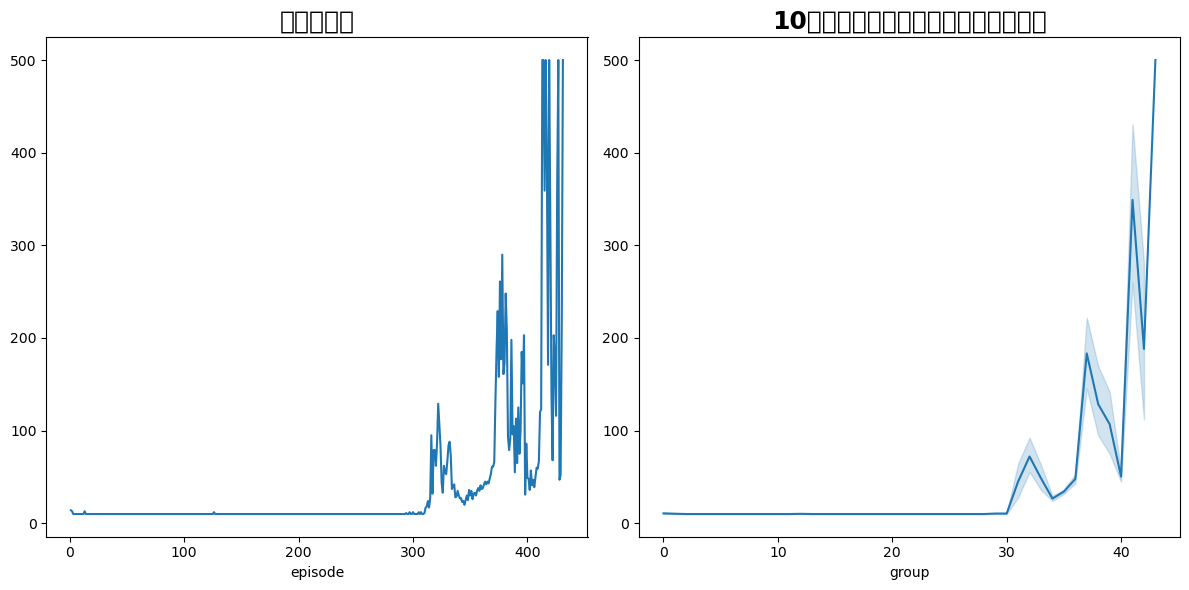

In [8]:
result_data = pd.read_csv(result_dir_path.joinpath('actor_critic_cartpole_result.csv'))

fig = plt.figure(figsize=(12, 6), facecolor='white')

ax = fig.add_subplot(1, 2, 1)
g = sns.lineplot(
    data=result_data,
    x='episode', y='reward',
    ax=ax
)
plt.title('報酬の推移', fontsize=18, weight='bold')
plt.ylabel('')

ax = fig.add_subplot(1, 2, 2)
g = sns.lineplot(
    data=result_data.assign(group=lambda x: x.episode.map(lambda y: math.floor((y - 1) / 10))),
    x='group', y='reward',
    ax=ax
)
plt.title('10エピソードごとの報酬平均値の推移', fontsize=18, weight='bold')
plt.ylabel('')

plt.tight_layout()
plt.savefig(result_dir_path.joinpath('actor_critic_cartpolcar_learning_reward.png'), dpi=300)

In [9]:
def select_action_valid(model, state, device):

    with torch.no_grad():
        state = torch.from_numpy(state).float()
        probs, state_value = model(state.to(device))

    return probs.argmax().item(), state_value

In [10]:
model = Policy()
model.load_state_dict(torch.load(model_dir_path.joinpath('actor_critic.pth')))
model.eval()

Policy(
  (affine): Linear(in_features=4, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=2, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
env = gymnasium.make('CartPole-v1', render_mode='human')
state, _ = env.reset()
episode_reward = 0
done = False
truncated = False
while not done and not truncated:

    action, state_value = select_action_valid(model=model, state=state, device=device)
    state, reward, done, truncated, _ = env.step(action)

    episode_reward += reward

print('Game End Reward: {:.0f}'.format(episode_reward))

/Users/choumasaki/ProjectCoral/torch-actorcritic/env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Game End Reward: 500
